In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import numpy as np
import tensorflow as tf
import scipy as sp
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def visualize_data(images, categories=None, class_names=None):
    fig = plt.figure(figsize=(14,6))
    fig.patch.set_facecolor('white')
    for i in range(min(3*7, len(images))):
        plt.subplot(3,7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        if class_names and categories is not None:
            class_index = categories[i].argmax()
            plt.xlabel(class_names[class_index])
    plt.show()

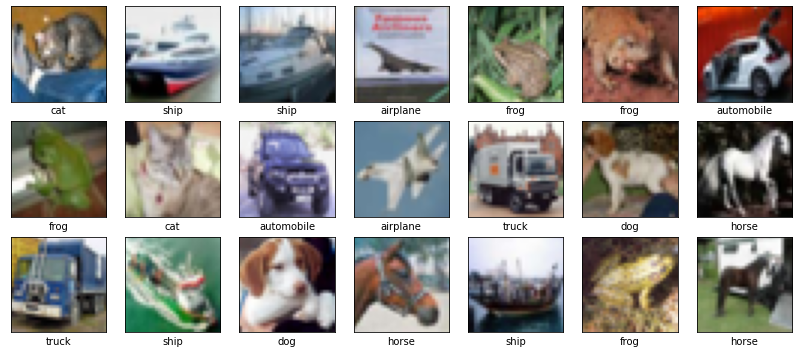

In [4]:
# load cifar-10 and visualize

class_names = ['airplane', 'automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

visualize_data(x_test, y_test, class_names)

In [5]:
def create_model():
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        alpha=0.35,
        input_shape=(96,96,3),
        )
    base_model.trainable = False

    inputs = layers.Input(shape=(32, 32, 3), dtype= tf.uint8)
    x = tf.cast(inputs, tf.float32)
    x = preprocess_input(x)
    x = layers.UpSampling2D(size=(3,3), interpolation='nearest')(x)

    x = base_model(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x) 

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy']
                  )
    return model

In [6]:
batch_size = 32
epochs = 5
m = create_model()
m.summary()

history = m.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=1)

2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_0.35_96 (Model)  (None, 1280)              410208    
________________________________________________________________

In [8]:
_, acc = m.evaluate(x_test, y_test)
acc

313/313 [==============================] - 12s 39ms/step - loss: 0.5863 - accuracy: 0.8074


0.8073999881744385

In [12]:
#wrong augumentation

_, acc = m.evaluate(x_test, y_test)

#augmentation: random flip:
datagen_flip = ImageDataGenerator(horizontal_flip=True)
datagen_flip.fit(x_test)

#augmentation: random shift
datagen_shift = ImageDataGenerator(width_shift_range = 3. /32.)
datagen_shift.fit(x_test)

_, acc_flip = m.evaluate(datagen_flip.flow(x_test, y_test, shuffle =False))
_, acc_shift = m.evaluate(datagen_shift.flow(x_test, y_test, shuffle = False))
print(acc, acc_flip, acc_shift)               

313/313 [==============================] - 12s 39ms/step - loss: 0.6446 - accuracy: 0.7858
0.8073999881744385 0.8068000078201294 0.7857999801635742


In [15]:
#Not efficient

def eval_random(model, datagen, x, y, epochs = 4):
    datagen.fit(x)
    
    predictions = []
    acc_history = []
    
    pred = model.predict(x)
    predictions.append(pred)
    
    for i in range(epochs):
        prediction = model.predict(datagen.flow(x, shuffle=False)) #augmentation 
        predictions.append(prediction)
        
    predictions = np.stack(predictions)
    acc_history = agg_preds(predictions, y)
    
    return acc_history

def agg_preds(predictions, y):
    y_classes = np.argmax(y, axis=1)
    acc_hist = []
    
    for i in range(predictions.shape[0]):
        pred_agg = np.mean(predictions[:i+1], axis = 0)
        preds = np.argmax(pred_agg, axis =1)
        acc = preds == y_classes
        acc = np.mean(acc)
        acc_hist.append(acc)
    return acc_hist

epochs = 16
acc_flip = eval_random(m, datagen_flip, x_test, y_test, epochs=epochs)
acc_shift = eval_random(m, datagen_shift, x_test, y_test, epochs=epochs)

In [24]:
print(acc_flip, acc_shift)

[0.8074, 0.8133, 0.816, 0.816, 0.815, 0.8171, 0.8165, 0.8169, 0.8161, 0.8156, 0.8165, 0.8162, 0.8154, 0.8166, 0.8166, 0.8164, 0.8165] [0.8074, 0.8101, 0.8107, 0.8086, 0.8088, 0.8078, 0.8094, 0.8088, 0.8084, 0.8082, 0.8086, 0.8079, 0.808, 0.807, 0.8082, 0.8081, 0.8073]


In [17]:
#Efficient

def flip_lr(images):
    return np.flip(images, axis=2)
def shift(images, shift, axis):
    return np.roll(images, shift, axis = axis)
def rotate(images, angle):
    return sp.ndimage.rotate(images, angle, axes =(1,2), reshape=False, mode='nearest')

# Create the needed augmentations:

pred = m.predict(x_test)

pred_f = m.predict(flip_lr(x_test))

pred_w0 = m.predict(shift(x_test, -3, axis =2))
pred_w1 = m.predict(shift(x_test, 3, axis = 2))

pred_h0 = m.predict(shift(x_test, -3, axis =1))
pred_h1 = m.predict(shift(x_test, 3, axis = 1))

pred_r0 = m.predict(rotate(x_test, -10))
pred_r1 = m.predict(rotate(x_test, 10))

In [ ]:
def aff_acc(predictions, y):
    y_classes = np.argmax(y, axis = 1)
    pred_agg = np.mean(predictions, axis =0)
    preds = np.argmax(pred_agg, axis =1)
    acc = np.mean(preds == y_classes)
    return acc

preds_f = np.stack((pred, pred_f))
acc_f


In [23]:
preds_f = np.stack((pred, pred_f))
acc_f = aff_acc(preds_f, y_test)

array([[[1.11807121e-05, 4.15967088e-06, 2.21579612e-05, ...,
         2.32636239e-06, 2.88261836e-05, 3.94118231e-08],
        [6.26528636e-05, 3.08089852e-02, 1.14082734e-08, ...,
         1.94193088e-08, 9.69127953e-01, 1.28118444e-07],
        [1.23843767e-01, 3.40251029e-02, 5.61255030e-04, ...,
         1.57038186e-04, 8.39816570e-01, 5.35361818e-04],
        ...,
        [1.42177072e-04, 1.52753619e-05, 4.76016942e-03, ...,
         7.87329511e-04, 2.13576815e-04, 1.66529014e-06],
        [7.85160363e-01, 2.57788971e-02, 1.66313618e-01, ...,
         6.29985239e-04, 7.50413677e-03, 6.81236852e-04],
        [2.77714962e-09, 1.61218594e-08, 3.66815129e-06, ...,
         9.93580222e-01, 3.93386365e-11, 2.21080843e-08]],

       [[1.44792243e-03, 1.29835494e-03, 7.12880981e-04, ...,
         2.99781241e-04, 1.47587550e-03, 2.58799882e-05],
        [1.21072924e-04, 5.54380473e-03, 1.01986579e-08, ...,
         7.07827255e-08, 9.94334936e-01, 1.52648695e-07],
        [3.12226079e-02, 

In [43]:
np.mean(preds_f, axis = 0)

array([[7.2955160e-04, 6.5125729e-04, 3.6751947e-04, ..., 1.5105380e-04,
        7.5235084e-04, 1.2959700e-05],
       [9.1862894e-05, 1.8176395e-02, 1.0803466e-08, ..., 4.5101018e-08,
        9.8173141e-01, 1.4038358e-07],
       [7.7533185e-02, 8.3486997e-02, 6.8459281e-04, ..., 1.3337699e-04,
        8.3681631e-01, 4.1351494e-04],
       ...,
       [1.8681868e-04, 3.6803507e-05, 6.2090261e-03, ..., 8.0484198e-04,
        1.5464498e-03, 6.5488416e-06],
       [6.6601503e-01, 1.3401759e-01, 1.6157371e-01, ..., 5.4843334e-04,
        1.9925313e-02, 3.1055929e-03],
       [2.9017553e-09, 1.5786572e-08, 2.1071482e-06, ..., 9.9631679e-01,
        2.8815252e-11, 1.4279887e-08]], dtype=float32)

In [44]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10.,
        fill_mode='reflect',
        width_shift_range = 0.1, 
        height_shift_range = 0.1)